# Current Population Survey AdaBoost Regression

An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases. 

Using AdaBoost Regression to predict each of the numerical variables in the dataset. 

In [1]:
import numpy as np
import pandas as pd
from collections import OrderedDict
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from sklearn.metrics import mean_squared_error, r2_score
from sklearn import ensemble

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import dataset
# We only need numerical values for regression
data = pd.read_csv("../datasets/CPS2016_UPDATE.csv", 
                  usecols=['age', 'weekly_hrs', 'educ', 
                'fam_income', 'num_in_house', 'num_child']).astype(float)

# We are going to use the entire dataset for this model
# to test on a smaller sample uncomment below
# data = data.sample(n=1000)

T = ensemble.AdaBoostRegressor()

# Apply 80/20 training/testing split
# Results may vary each time the data is split
data_train, data_test = train_test_split(data, test_size=0.2)
data.head()

age  weekly_hrs  educ  fam_income  num_in_house  num_child
0  28.0        40.0  11.0        11.0           6.0        4.0
1  44.0        50.0  13.0        16.0           5.0        2.0
2  23.0        20.0   9.0        14.0           3.0        0.0
3  20.0        20.0   7.0         9.0           5.0        0.0
4  20.0        20.0   9.0        13.0           4.0        0.0

In [3]:
# function to return necessary information about model
def scoreAdaBoostRegressor(x, y, xTest, yTest):

    reg = ensemble.AdaBoostRegressor()
    reg.fit(x,y)

    preds = reg.predict(xTest)
    print("R2 score : %.2f" % r2_score(yTest,preds))
    print("Mean squared error: %.2f" % mean_squared_error(yTest,preds))

    er = []
    g = 0
    for i in range(len(yTest)):
        x = (yTest[i] - preds[i]) **2
        er.append(x)
        g = g + x
    
    x = 0
    for i in range(len(er)):
       x = x + er[i]

    print ("MSE", x / len(er))

    v = np.var(er)
    print ("variance", v)

    print ("average of errors ", np.mean(er))

    m = np.mean(yTest)
    print ("average of observed values", m)

    y = 0
    for i in range(len(yTest)):
        y = y + ((yTest[i] - m) ** 2)

    print ("total sum of squares", y)
    print ("ẗotal sum of residuals ", g)
    print ("r2 calculated", 1 - (g / y)) 
    
# function to plot predictions vs training data    
def plotPredictions(data_train, data_test, prediction, target):
    fig, ax = plt.subplots(1,5, figsize=(15,3), dpi=100)
    loopData = data_train.drop(target, axis=1)
    for i, var in enumerate(loopData):
        ax[i].scatter(data_train[var], data_train[target], color='pink', marker='x', label='train')
        ax[i].scatter(data_test[var], data_test[target], color='red', marker='*', label='test', alpha=.2)
        ax[i].scatter(data_test[var], prediction, color='purple', marker='.', label='predicted', alpha=.9)
        ax[i].set_xlabel(var)
        ax[i].set_ylabel(target)
    
    # Remove duplicate labels    
    handles, labels = fig.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))    
    fig.legend(by_label.values(), by_label.keys())
    plt.show()     

# Predict Number of Persons Living in Household

In [4]:
target = 'num_in_house'
T.fit(data_train.drop(target, axis=1), data_train[target])
prediction = T.predict(data_test.drop(target, axis=1));

plotPredictions(data_train, data_test, prediction, target)    

In [5]:
# Score Model
xTest = np.array(data_test.drop(target, axis=1))
yTest = np.array(data_test[target])
                 
x = data_train.drop(target, axis=1)
y = data_train[target]
                 
scoreAdaBoostRegressor(x, y, xTest, yTest)                 

R2 score : 0.21
Mean squared error: 1.89
MSE 1.887846701866489
variance 16.49538548331627
average of errors  1.8878467018665628
average of observed values 3.0713057641842365
total sum of squares 26555.81105782236
ẗotal sum of residuals  20862.59390232657
r2 calculated 0.21438686783466843


In [6]:
# Score with cross validation
cvscore = cross_val_score(T, data.drop(target, axis=1), 
                          data[target], cv=KFold(shuffle=True, n_splits=5))
cvscore.mean()

0.22253598691331042

Linear Regression and Decision Tree Regression have very similar R2 scores, while AdaBoost is producing lower scores around .222. However, AdAboost produced lower variance than the other methods, and had the greatest MSE.

# Predict Number of own Children under 18 years of age

In [7]:
target = 'num_child'
T.fit(data_train.drop(target, axis=1), data_train[target])
prediction = T.predict(data_test.drop(target, axis=1));
plotPredictions(data_train, data_test, prediction, target)     

In [8]:
# Score Model
xTest = np.array(data_test.drop(target, axis=1))
yTest = np.array(data_test[target])
                 
x = data_train.drop(target, axis=1)
y = data_train[target]
                 
scoreAdaBoostRegressor(x, y, xTest, yTest)   

R2 score : 0.47
Mean squared error: 0.54
MSE 0.539097570987521
variance 1.241012079853725
average of errors  0.5390975709875302
average of observed values 0.6011220704008687
total sum of squares 11331.746086326193
ẗotal sum of residuals  5957.567256983095
r2 calculated 0.4742586701468735


In [9]:
# Score with cross validation
cvscore = cross_val_score(T, data.drop(target, axis=1), 
                          data[target], cv=KFold(shuffle=True, n_splits=5))
cvscore.mean()

0.47402012067022153

AdaBoost Regression for predicting num_child produces an R2 score that is significantly greater than the score produced by Linear Regression, but less than the score produced by Decision Tree Regression.

# Predict Family Income (Numerical Value)
Family income is represented by integers 1 - 16, each representing increaseng income groups ranging from 'less than 5,000' to 'greater than 150,000'. Refer to dataset description for more information.

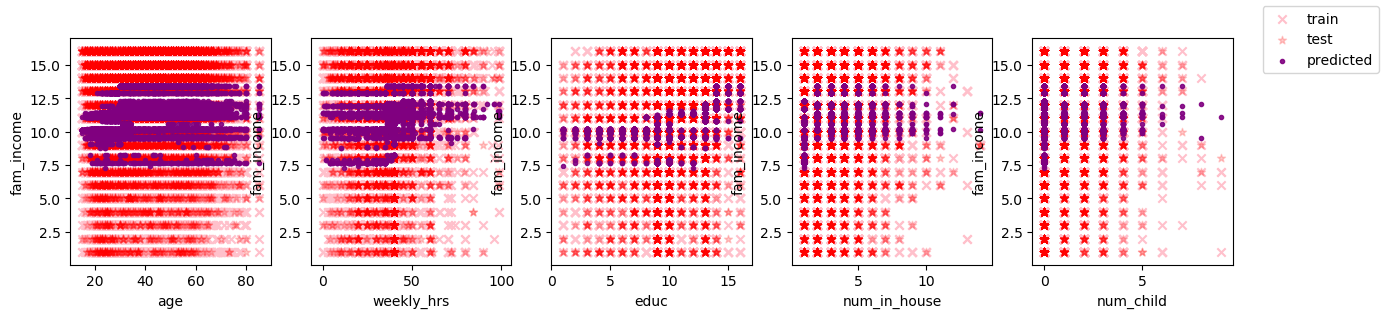

In [10]:
target = 'fam_income'
T.fit(data_train.drop(target, axis=1), data_train[target])
prediction = T.predict(data_test.drop(target, axis=1));
plotPredictions(data_train, data_test, prediction, target)    

In [11]:
# Score Model
xTest = np.array(data_test.drop(target, axis=1))
yTest = np.array(data_test[target])
                 
x = data_train.drop(target, axis=1)
y = data_train[target]
                 
scoreAdaBoostRegressor(x, y, xTest, yTest)   

R2 score : 0.07
Mean squared error: 11.21
MSE 11.207636810719816
variance 203.91527018219745
average of errors  11.20763681071977
average of observed values 12.203601484028594
total sum of squares 133387.89666093962
ẗotal sum of residuals  123855.59439526468
r2 calculated 0.07146302254023251


In [12]:
# Score with cross validation
cvscore = cross_val_score(T, data.drop(target, axis=1), 
                          data[target], cv=KFold(shuffle=True, n_splits=5))
cvscore.mean()

0.11681593346611445

The R2 score is very low when predicting family income. The R2 score produced using Decision Tree Regression has a slightly larger R2 score than the other methods. The variance, and MSE are similar for each of the regression methods used.

# Predict Age

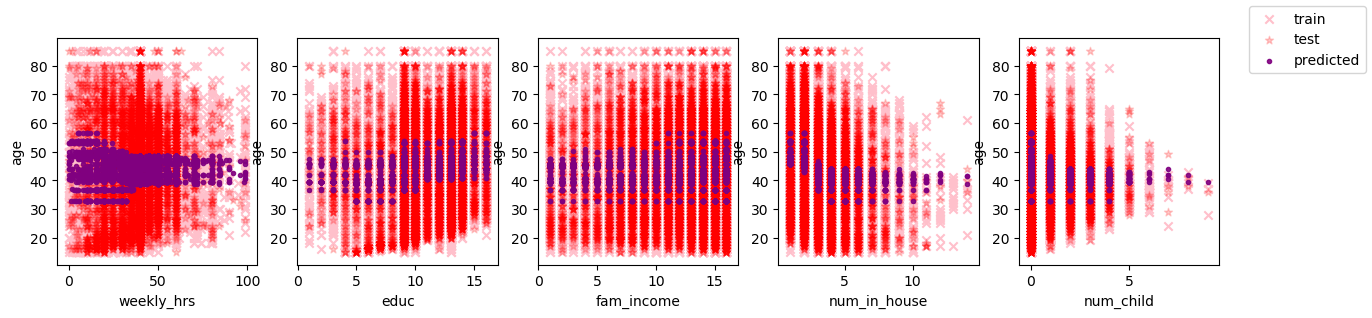

In [13]:
target = 'age'
T.fit(data_train.drop(target, axis=1), data_train[target])
prediction = T.predict(data_test.drop(target, axis=1));
plotPredictions(data_train, data_test, prediction, target)   

In [14]:
# Score Model
xTest = np.array(data_test.drop(target, axis=1))
yTest = np.array(data_test[target])
                 
x = data_train.drop(target, axis=1)
y = data_train[target]
                 
scoreAdaBoostRegressor(x, y, xTest, yTest)   

R2 score : 0.11
Mean squared error: 186.81
MSE 186.81126559799552
variance 41576.5516093192
average of errors  186.81126559799873
average of observed values 42.71930142068591
total sum of squares 2319815.2730069864
ẗotal sum of residuals  2064451.2961234483
r2 calculated 0.11007944462428276


In [15]:
# Score with cross validation
cvscore = cross_val_score(T, data.drop(target, axis=1), 
                          data[target], cv=KFold(shuffle=True, n_splits=5))
cvscore.mean()

0.11811647209810852

The R2 score is low for each method when predicting age.

# Predict Hours Worked Weekly

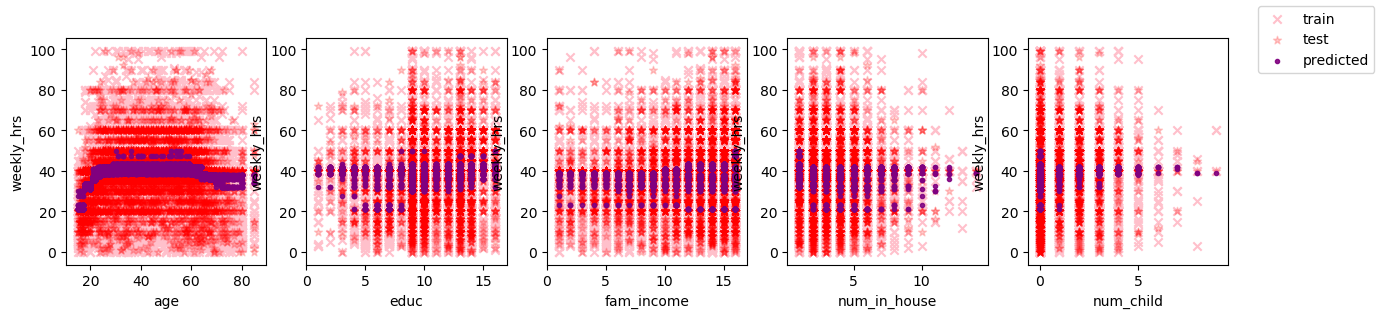

In [16]:
target = 'weekly_hrs'
T.fit(data_train.drop(target, axis=1), data_train[target])
prediction = T.predict(data_test.drop(target, axis=1));
plotPredictions(data_train, data_test, prediction, target)   

In [17]:
# Score Model
xTest = np.array(data_test.drop(target, axis=1))
yTest = np.array(data_test[target])
                 
x = data_train.drop(target, axis=1)
y = data_train[target]
                 
scoreAdaBoostRegressor(x, y, xTest, yTest)  

R2 score : 0.09
Mean squared error: 105.88
MSE 105.87995048263407
variance 69587.00960971712
average of errors  105.87995048263363
average of observed values 39.31119355714415
total sum of squares 1292384.8053568848
ẗotal sum of residuals  1170079.3327835891
r2 calculated 0.09463549251457015


In [18]:
# Score with cross validation
cvscore = cross_val_score(T, data.drop(target, axis=1), 
                          data[target], cv=KFold(shuffle=True, n_splits=5))
cvscore.mean()

0.09319627511428578

The R2 score is low for each method when predicting weekly_hrs.

# Predict Education Level
Education level is represented by integers 31-46, each representing increaseng levels of education from 'less than first grade' to 'doctorates degree'. Refer to dataset description for more information.

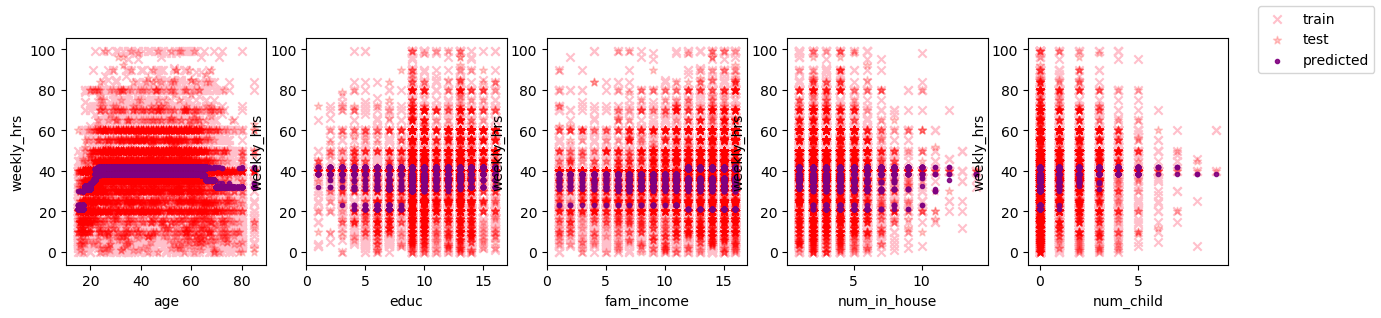

In [19]:
target = 'weekly_hrs'
T.fit(data_train.drop(target, axis=1), data_train[target])
prediction = T.predict(data_test.drop(target, axis=1));
plotPredictions(data_train, data_test, prediction, target)   

In [20]:
# Score Model
xTest = np.array(data_test.drop(target, axis=1))
yTest = np.array(data_test[target])
                 
x = data_train.drop(target, axis=1)
y = data_train[target]
                 
scoreAdaBoostRegressor(x, y, xTest, yTest)  

R2 score : 0.09
Mean squared error: 106.13
MSE 106.13234139860724
variance 69932.32144189466
average of errors  106.13234139860147
average of observed values 39.31119355714415
total sum of squares 1292384.8053568848
ẗotal sum of residuals  1172868.5047960086
r2 calculated 0.09247733342692199


In [21]:
# Score with cross validation
cvscore = cross_val_score(T, data.drop(target, axis=1), 
                          data[target], cv=KFold(shuffle=True, n_splits=5))
cvscore.mean()

0.0981161789977268

The R2 score is somewhat low for each method when predicting weekly_hrs, however Decision Tree Regression produces a significantly larger score.

# Conclusion

Although we predicted different variables from the dataset vs the categorical variables predicted when we use classification methods, the effectiveness of applying regression methods for predicting the numerical variables of this dataset aren't as effective as the results obtained in classification. Larger scores were produced when using supervised classification. Using regression to predict the binary categorical variables 'ismarried' and 'faminc_50' did not make sense using regression.

- The most effective prediction using supervised regression methods on this dataset was predicting 'Number of children under 18 years old' using Decision Tree Regression. The largest R2 score achieved was .5993. 
- The second most effective prediction using supervised regression methods on this dataset was predicting 'Number of Persons Living in Household' using Decision Tree Regression. The largest R2 score achieved was .4283

AdAboost was more effective than Linear Regression, but Decision Tree Regression proved to be the more effective regression method for this dataset.